# Example 1: 2 circles in 2D

In this example, we use the PLoM to learn the intrinsic structure of the training data and generate replicas drawn from the same statistical distribution.

The training data consists of 400 data points that lie around two circles of different diameters (plotted below).

## Importing modules

In this notebook, it is assumed that the PLoM package is installed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plom
from plom import initialize, run

ModuleNotFoundError: No module named 'plom'

## Loading training data
Rows are observations, columns are features.

In [1]:
training = np.loadtxt('data/training_2circles_data_e0.15.txt')
print(training.shape)

NameError: name 'np' is not defined

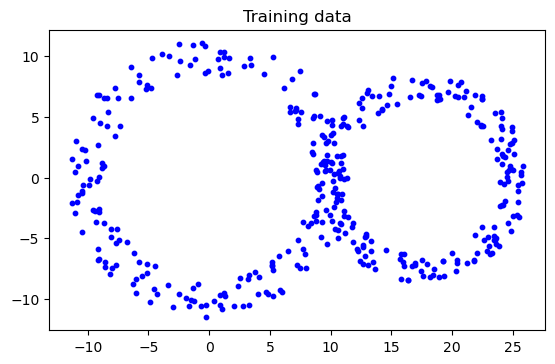

In [3]:
plt.figure()
plt.scatter(training[:, 0], training[:, 1], color='b', s=10, label='Training')
plt.gca().set_aspect('equal')
plt.title('Training data')
plt.show()

## PLoM run

### Defining dictionary of parameters for the PLoM run

In [5]:
args  =  {
          "training"          : training,

          "scaling"           : True,
          "scaling_method"    : 'Normalization',
        
          "pca"               : False,
          "pca_method"        : 'cum_energy',
          "pca_cum_energy"    : 0.999,

          "dmaps"             : True,
          "dmaps_epsilon"     : 'auto',

          "sampling"          : True,
          "num_samples"       : 10,
          "parallel"          : False,
          "save_samples"      : True,
          "samples_fname"     : 'data/new_samples.txt',

          "job_desc"          : "2_circles",
          "verbose"           : True
          }

### Creating a PLoM dictionary with the above parameters

In [6]:
solution_dict = initialize(**args)
## for simple runs, an argument dictionary is not needed as most defaults are not modified:
# solution_dict = plom.initialize(training=training, dmaps=True, dmaps_epsilon='auto', sampling=True, num_samples=10, samples_fname='data/new_samples')

In [ ]:
solution_dict = initialize(training=training, scaling=True, ...)

### `run(solution_dict)` is called to run the sequence of steps (scaling, pca, dmaps, sampling, post-processing)
All computations are saved into the solution dictionary initialized above.

In [7]:
run(solution_dict)
### DMaps and sampling can also be run separately: ###
# from plom import run_dmaps, run_sampling
# run_dmaps(solution_dict)
# run_sampling(solution_dict)


PLoM run starting at 2022-03-21 23:35:17


Scaling data.
-------------
Input data dimensions: (400, 2)
Using 'Normalization' scaler.
Output data dimensions: (400, 2)


Performing PCA.
---------------
Input data dimensions: (400, 2)
PCA eigenvalues: [0.95648573 1.0485268 ]
Criteria for truncation: cumulative energy content = 0.999
PCA retained eigenvalues: [0.95648573 1.0485268 ]
PCA cumulative energy content = 1.0
Number of features: 2 -> 2
Output data dimensions: (400, 2)


Performing DMAPS analysis.
--------------------------
Input data dimensions: (400, 2)
Finding best epsilon for analysis.
Epsilon = 15.60
Manifold eigenvalues: 0.12291802 0.12095759 0.0122577  [...]
Manifold dimension: m optimal = 2
m used = 2
Using 2 DMAPS eigenvectors (1 to 2).
DMAPS data dimensions: (400, 2)
*** DMAPS time = 0:00:00.387 ***


Performing Ito sampling.
------------------------
Projected data (Z) dimensions: (2, 2)
From Ito sampler: fac = 21.744
From Ito sampler: 184.2 steps needed; 185 steps  prov

### DMaps eigenvalues are saved and can be plotted with `plom.plot_dmaps_eigenvalues(solution_dict)`

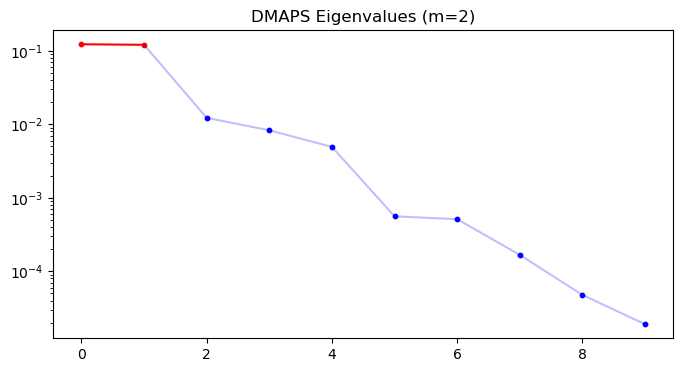

In [8]:
plom.plot_dmaps_eigenvalues(solution_dict)

### DMaps eigenvectors are saved and the retained vectors can be plotted with 
### `plom.plot2D_dmaps_basis(solution_dict)`

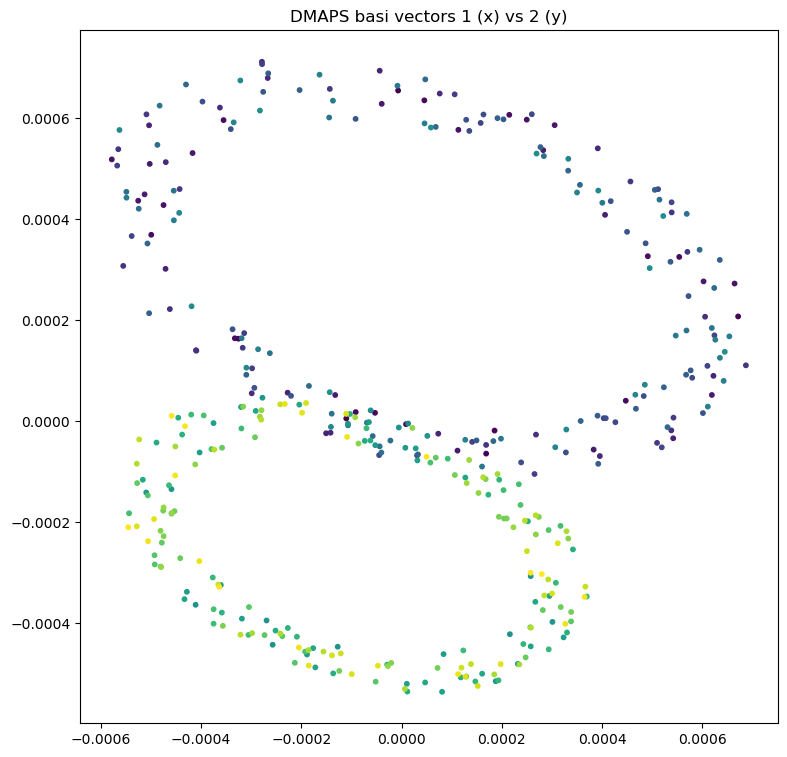

In [9]:
plom.plot2D_dmaps_basis(solution_dict)

### Generated samples can be accessed in the solution dictionary

In [10]:
new_samples = solution_dict['data']['augmented']
print('Training data: ', training.shape)
print('Generated data: ', new_samples.shape)

Training data:  (400, 2)
Generated data:  (4000, 2)


### 2D training samples and generated samples can be plotted with `plom.plot2d_samples(solution_dict)`

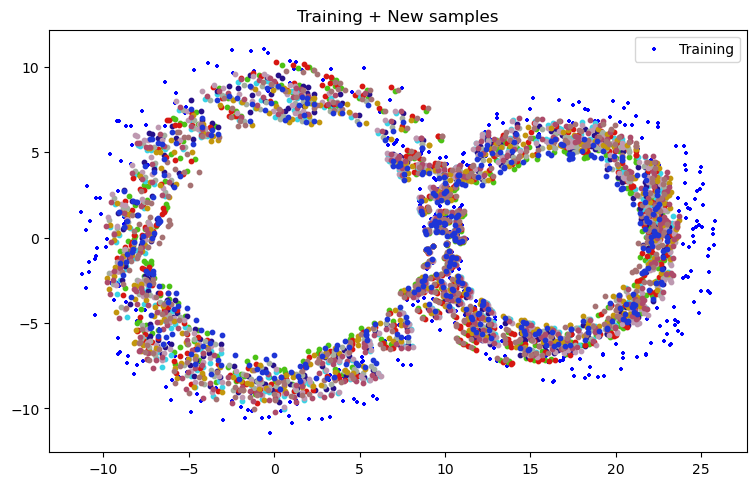

In [11]:
plom.plot2d_samples(solution_dict)

## The generated samples can be used to estimate conditional distributions
### The block below computes a conditional KDE of column 2 (Y) conditioned on column 1 (X=15)

In [12]:
qoi_cols = 1 # index (or list of indices) of feature(s) for which we compute conditional pdf
cond_cols = 0 # index (or list of indices) of feature(s) we condition on
cond_vals = 15 # value(s) of condition(s)
cond_pdf = plom.conditional_pdf(solution_dict, qoi_cols, cond_cols, cond_vals, pdf_Npts=200) # return is (x,y) data for the PDF
print(cond_pdf.shape)


***********************************************************
Conditioning starting at 2022-03-21 23:36:28

Estimating the marginal distribution of <variable 1> conditioned on <variable 0> = <15>.
Using N = 4000 samples.

Computing conditioning weights.
Using bw = 0.250990 for conditioning weights.

Generating PDF evaluation grid from data (200 pts per dimension, 200 points in total).

Computing kernel bandwidth using Silverman's rule of thumb.
Bandwidth used = [1.271646]

Evaluating KDE on 200 points in parallel.

Conditioning complete at 2022-03-21 23:36:31
Time = 0:00:03
(200, 2)


### The block below computes an unconditional KDE of column 2 (Y)

In [13]:
from scipy.stats import gaussian_kde as gkde

kde_Npts = 200
data = training[:, 1]
kde_kernel = gkde(data)
xmin = data.min()
xmax = data.max()
xpdf = np.linspace(xmin, xmax, kde_Npts)
ypdf = kde_kernel(xpdf)

### The conditional and unconditional PDFs are plotted

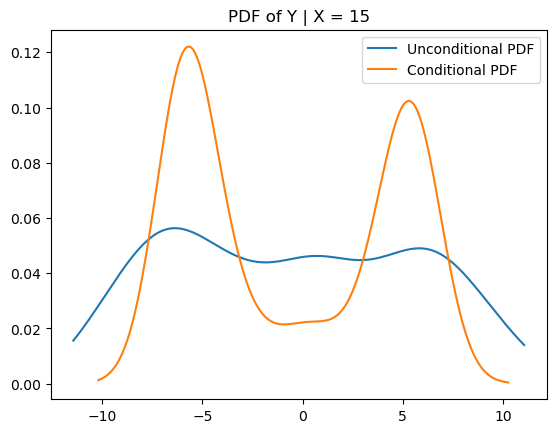

In [14]:
plt.figure()
plt.plot(xpdf, ypdf, label='Unconditional PDF')
plt.plot(cond_pdf[:, 0], cond_pdf[:, 1], label='Conditional PDF')
plt.legend()
plt.title('PDF of Y | X = 15')
plt.show()

## Conditional expectation, E(Y | X=15), can also be computed

In [16]:
qoi_cols = 1 # feature(s) for which we compute conditional pdf
cond_cols = 0 # feature(s) we condition on
cond_vals = 15 # value(s) of condition(s)
cond_exp, cond_var = plom.conditional_expectation(solution_dict, qoi_cols, cond_cols, cond_vals)
print('\n\nConditional expectation = ', cond_exp)


***********************************************************
Conditional expectation evaluation starting at 2022-03-21 23:37:06

Estimating the conditional expectation of <variable 1> conditioned on <variable 0> = <15>.
Using N = 4000 samples.

Computing conditioning weights.
Using bw = 0.250990 for conditioning weights.

Computing expectation value.

Conditional expected value of variable(s) 1: E = -0.6030214628542666

Conditional variance of variable(s) 1: Var = 26.766296998215402

Conditioning complete at 2022-03-21 23:37:06
Time = 0:00:00


Conditional expectation =  -0.6030214628542666
